In machine learning, a number of representations for floating point numbers are used that have been introduced in recent years.  In this notebook, you can explore those types to understand their semantics.

The representation fall into two main categories:
* floating point: FP16 and BF16
* integer: INT8

## Converting to floating point representations

First, a number of functions are defined to do the heavy lifting of converting a Python `float` (64-bit, double precision) to a bit representation with sign bit, and a given number of bits representing the mantissa and the exponent.

The following values are used as a running example:

In [47]:
x = 5.239
nr_mantissa_bits = 23
nr_exponent_bits = 8

The function `compute_fractional_bits` will compute a bit representation of the fractional part of a floating point number, e.g., consider the number 5.239, the fractional part is 0.239.  The integer part of this number would of course be 5.

In [15]:
def compute_fractional_bits(x, nr_bits=23):
    bits = []
    for _ in range(nr_bits):
        if x == 0:
            return bits + [0]*(nr_bits - len(bits))
        x *= 2
        if x >= 1:
            bits.append(1)
            x %= 1
        else:
            bits.append(0)
    return bits

In [49]:
compute_fractional_bits(x % 1, nr_bits=nr_mantissa_bits)

[0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1]

If the integer part of a floating point number is 0, it is more convenient to compute all bits of the fractional part, up to the first significant bit, i.e., up to the first bit that has the value 1.  The function `compute_first_significant_bit` does this.  It also returns the fractional value at that point so that the algorithm can continue from that point onwards.

In [52]:
def compute_first_significant_bit(x):
    bits = []
    while x != 0:
        x *= 2
        if x >= 1:
            bits.append(1)
            break
        else:
            bits.append(0)
    return bits, x % 1

In [53]:
compute_first_significant_bit(x % 1)

([0, 0, 1], 0.911999999999999)

The function `compute_mantissa_exponent_bits` computes the bit representation of the integer and the fractional part of the given `float` number.  The numbr of bits for the mantissa's representation can be specified.

In [54]:
def compute_mantissa_exponent_bits(x, nr_mantissa_bits=23):
    integer_bits = [int(bit) for bit in f'{int(x):b}']
    if integer_bits == [0]:
        first_bits, x = compute_first_significant_bit(x)
        fractional_bits = first_bits + compute_fractional_bits(x, nr_mantissa_bits)
    else:
        fractional_bits = compute_fractional_bits(x % 1, nr_bits=nr_mantissa_bits - len(integer_bits) + 1)
    return integer_bits, fractional_bits

In [58]:
integer_bits, fractional_bits = compute_mantissa_exponent_bits(x, nr_mantissa_bits=nr_mantissa_bits)
print(integer_bits, fractional_bits)

[1, 0, 1] [0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1]


To get the final representation, the bit representation has to be normalized, i.e,, scaled such that the integer part is a single bit 1, and the mantissa has (at least) the appropriate number of bits for the representation.  The function `normalize` will also return the exponent to compute the exponent bits later.

In [57]:
def normalize(integer_bits, fractional_bits):
    if len(integer_bits) > 1:
        return integer_bits[1:] + fractional_bits, len(integer_bits) - 1
    elif integer_bits[0] == 1:
        return fractional_bits, 0
    else:
        try:
            pos_1 = fractional_bits.index(1)
            return fractional_bits[pos_1 + 1:], -pos_1
        except ValueError:
            return fractional_bits, 0

In [59]:
normalize(integer_bits, fractional_bits)

([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1], 2)

The function `float_to_bits` computes the final representation and returns the sign bit, the exponent bits, and the mantissa bits.

In [45]:
def float_to_bits(x, nr_mantissa_bits=23, nr_exponent_bits=8):
    integer_bits, mantissa_bits = compute_mantissa_exponent_bits(x, nr_mantissa_bits=23)
    mantissa_bits, exponent = normalize(integer_bits, mantissa_bits)
    sign_bit = [0] if x >= 0 else [1]
    bias_exponent = exponent + 2**(nr_exponent_bits - 1) - 1
    if bias_exponent < 0 or bias_exponent > 2**nr_exponent_bits - 1:
        raise OverflowError()
    exponent_bits = [int(bit) for bit in f'{bias_exponent:b}']
    exponent_bits = [0]*(nr_exponent_bits - len(exponent_bits)) + exponent_bits
    return sign_bit, exponent_bits, mantissa_bits[:nr_mantissa_bits]

In [61]:
float_to_bits(x, nr_mantissa_bits=nr_mantissa_bits, nr_exponent_bits=nr_exponent_bits)

([0],
 [1, 0, 0, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1])

For FP16, the number of exponent bits is 5, the number of mantissa bits is 10.

In [62]:
float_to_bits(x, nr_mantissa_bits=10, nr_exponent_bits=5)

([0], [1, 0, 0, 0, 1], [0, 1, 0, 0, 1, 1, 1, 1, 0, 1])

For BF16, the number of exponent bits is 8, and the number of mantissa bits is 7.

In [63]:
float_to_bits(x, nr_mantissa_bits=7, nr_exponent_bits=8)

([0], [1, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 1, 1, 1])

Bear in mind that this implementation is intended to illustrate the conversion algorithm, an implementation intended for use in production would be significantly different.

In [86]:
import numpy as np
import struct

In [68]:
x32 = np.float32(x)

In [70]:
x32.nbytes

4

In [104]:
def print_bits(value):
    nr_bits = 8*value.nbytes
    if isinstance(value, np.float16):
        int_enc = 'H'
        float_end = 'e'
    elif isinstance(value, np.float32):
        int_enc = 'I'
        float_end = 'f'
    # Pack the float32 into a binary representation and unpack it as an integer
    [bits] = struct.unpack(f'>{int_enc}', struct.pack(f'>{float_end}', value))
    # Format as a 32-bit binary string
    return f"{bits:0{nr_bits}b}"

In [105]:
print_bits(x32)

'01000000101001111010010111100011'

In [106]:
x16 = np.float16(x)

In [107]:
print_bits(x16)

'0100010100111101'

## INT8 representation

The INT8 representation is straightforward to compute, first the value is scaled, and then clipped.

In [64]:
def float_to_int8(x):
    n = round(127*x)
    if n > 127:
        return 127
    elif n < -128:
        return -128
    else:
        return n

Of course, all values larger than 1.0 or less than -1.0 will be clipped to 127 and -128 respectively.

In [65]:
float_to_int8(5.239)

127

In [66]:
float_to_int8(0.239)

30

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
x = np.linspace(-2.0, 2.0, 10000)
y = np.vectorize(float_to_int8)(x)

In [20]:
y[5000:5030]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

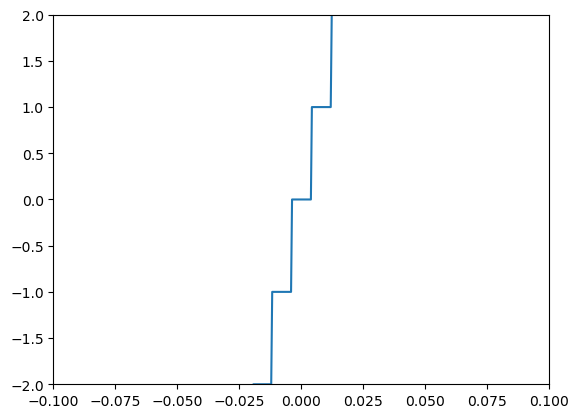

In [21]:
plt.plot(x, y);
plt.xlim(-0.1, 0.1)
plt.ylim(-2, 2);